### Imports
https://github.com/connorcoley/rexgen_direct/blob/master/notebooks/Data%20set%20analysis.ipynb <br>
https://github.com/Hanjun-Dai/GLN/tree/master/gln/data_process <br>
https://github.com/tentrillion/rdkit-tutorials/blob/master/notebooks <br>

In [97]:
import sys
import os
# sys.path.append('/usr/local/lib/python3.7/site-packages/') 
# for Colab 

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
import numpy as np

import matplotlib.pyplot as plt
params = {'text.usetex': True, 
          'text.latex.unicode': True,
          'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 6
plt.rcParams["text.latex.preamble"] = [
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath'
]

from itertools import chain
import random

from rdkit.Chem import PandasTools
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

C:\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


### Load data from Jin et al 
https://github.com/wengong-jin/nips17-rexgen 

USPTO/data.zip includes the train/dev/test split of USPTO dataset used in our paper. It has in total 480K fully atom mapped reactions. <br> Each line in the file has two fields, separated by space:

- Reaction smiles (both reactants and products are atom mapped)
- Reaction center. That is, atom pairs whose bonds in between changed in the reaction. Atoms are represented by their atom map number given in the reaction smiles.

In [68]:
USPTO50 = {'train': None, 'valid': None, 'test': None}

for key in USPTO50.keys():
    with open(os.getcwd()+'/data/Jin_USPTO_1product_{}.txt'.format(key), 'r') as file:
        lines = str(file.read()).split('\n')
        USPTO50[key] = [line.split()[0] for line in lines[1:]]

In [69]:
for key in USPTO50.keys():
    print('{}: {} total reactions'.format(key, len(USPTO50[key])))
    print('{}: {} unique reactions \n'.format(key, len(set(USPTO50[key]))))

train: 395497 total reactions
train: 395497 unique reactions 

valid: 29076 total reactions
valid: 29076 unique reactions 

test: 38648 total reactions
test: 38648 unique reactions 



In [70]:
from collections import Counter
num_rcts = {}
for key in USPTO50.keys():
    num_rcts_list = [smarts.split('>>')[0].count('.')+1 for smarts in USPTO50[key]]
    num_rcts[key] = Counter(num_rcts_list)
    
num_rcts['train']

Counter({4: 69396,
         3: 66291,
         2: 62603,
         5: 63313,
         6: 54563,
         8: 20267,
         7: 36117,
         12: 1869,
         9: 10238,
         13: 936,
         10: 5295,
         11: 3568,
         14: 443,
         15: 226,
         21: 93,
         16: 115,
         24: 3,
         22: 39,
         20: 6,
         23: 8,
         19: 17,
         18: 30,
         17: 58,
         25: 1,
         26: 1,
         29: 1})

### Check equivalence of reactants
- Limitation of using period to split the SMILES
- CXSmiles (extended SMILES) 
- check unimolecular reactions

In [71]:
num_prods = {}
for key in USPTO50.keys():
    num_prods_list = [smarts.split('>>')[-1].count('.')+1 for smarts in USPTO50[key]]
    num_prods[key] = Counter(num_prods_list)
    
num_prods['train']

Counter({1: 395497})

In [72]:
# os.makedirs(os.getcwd()+'/analysis')
# os.listdir()

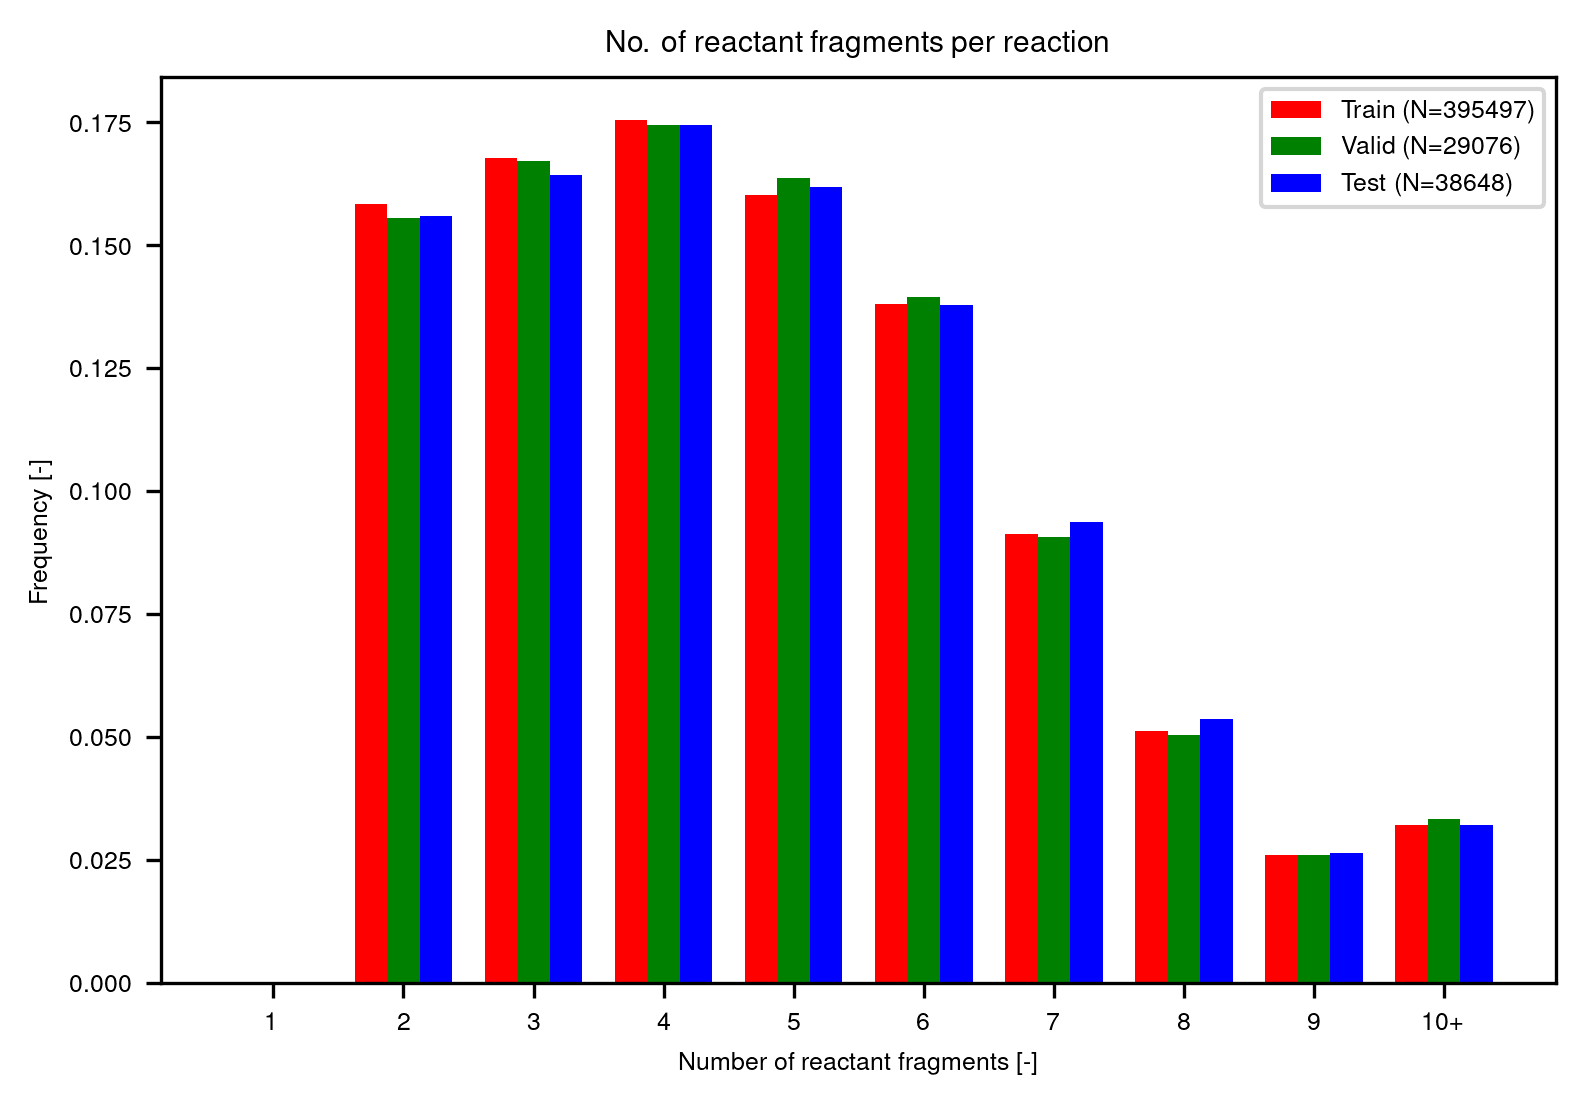

In [73]:
n = 11

fig = plt.figure(figsize=(6,4), dpi = 300)
colors = ['r', 'g', 'b']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    counter = num_rcts[key]
    counts_sum = sum(counter.values())
    xs = np.arange(1, n)
    xs[-1] = 1e9
    counts = np.zeros(np.shape(xs))
    for (k, v) in sorted(counter.items(), key=lambda x: x[0], reverse=True):
        for i in range(len(counts)):
            if xs[i] >= k:
                counts[i] = counts[i] + v
                break
    plt.bar(np.arange(len(counts)) + (offset-1)*.25, 
            counts / counts_sum, width=0.25,
            color=colors[offset])
    
plt.xlabel('Number of reactant fragments [-]')
xticklabels = [str(k) for k in xs if k != 1e9]
xticklabels.append('{}+'.format(xs[-2]+1))
plt.xticks(range(len(counts)), xticklabels)
plt.ylabel('Frequency [-]')
plt.legend(['Train (N={})'.format(len(USPTO50['train'])), 
            'Valid (N={})'.format(len(USPTO50['valid'])), 
            'Test (N={})'.format(len(USPTO50['test']))])
plt.title('No. of reactant fragments per reaction') # Raised Error when I used '# of reactants' instd of #No. of
plt.savefig(os.getcwd()+'/analysis/num_reactant_frags.png', bbox_inches = 'tight')
plt.show()

### Print all elements in reactants. Takes a while
https://regexr.com/

In [74]:
from collections import defaultdict
import re 

atom_id_rcts = {}
for key in USPTO50.keys():
    occurrences = defaultdict(int)
    for smarts in USPTO50[key]:
        rcts = smarts.split('>')[0]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_rcts[key] = occurrences
    
atom_id_prods = {}
for key in USPTO50.keys():
    occurrences = defaultdict(int)
    for smarts in USPTO50[key]:
        rcts = smarts.split('>')[-1]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_prods[key] = occurrences
    
all_atom_types = set()
for key in USPTO50.keys():
    all_atom_types |= set(atom_id_rcts[key].keys())
all_atom_types = sorted(all_atom_types, key=lambda x: atom_id_rcts['train'][x], reverse=True)

print(all_atom_types)

['c', 'o', 'n', 'cl', 'f', 's', 'na', 'br', 'k', 'p', 'i', 'b', 'li', 'si', 'pd', 'cs', 'al', 'cu', 'mg', 'sn', 'zn', 'fe', 'cr', 'mn', 'ti', 'pt', 'ca', 'ag', 'se', 'ni', 'ru', 'rh', 'os', 'co', 'pb', 'ba', 'ce', 'as', 'yb', 'w', 'zr', 'bi', 'ge', 'in', 'sc', 'tl', 'mo', 'ir', 'sm', 'sb', 're', 'au', 'xe', 'cd', 'ga', 'ta', 'v', 'rb', 'y', 'dy', 'la', 'te', 'be', 'pr', 'ar', 'nd', 'eu']


Freq Carbon in train: 68.55%
Freq Carbon in valid: 68.59%
Freq Carbon in test: 68.54%


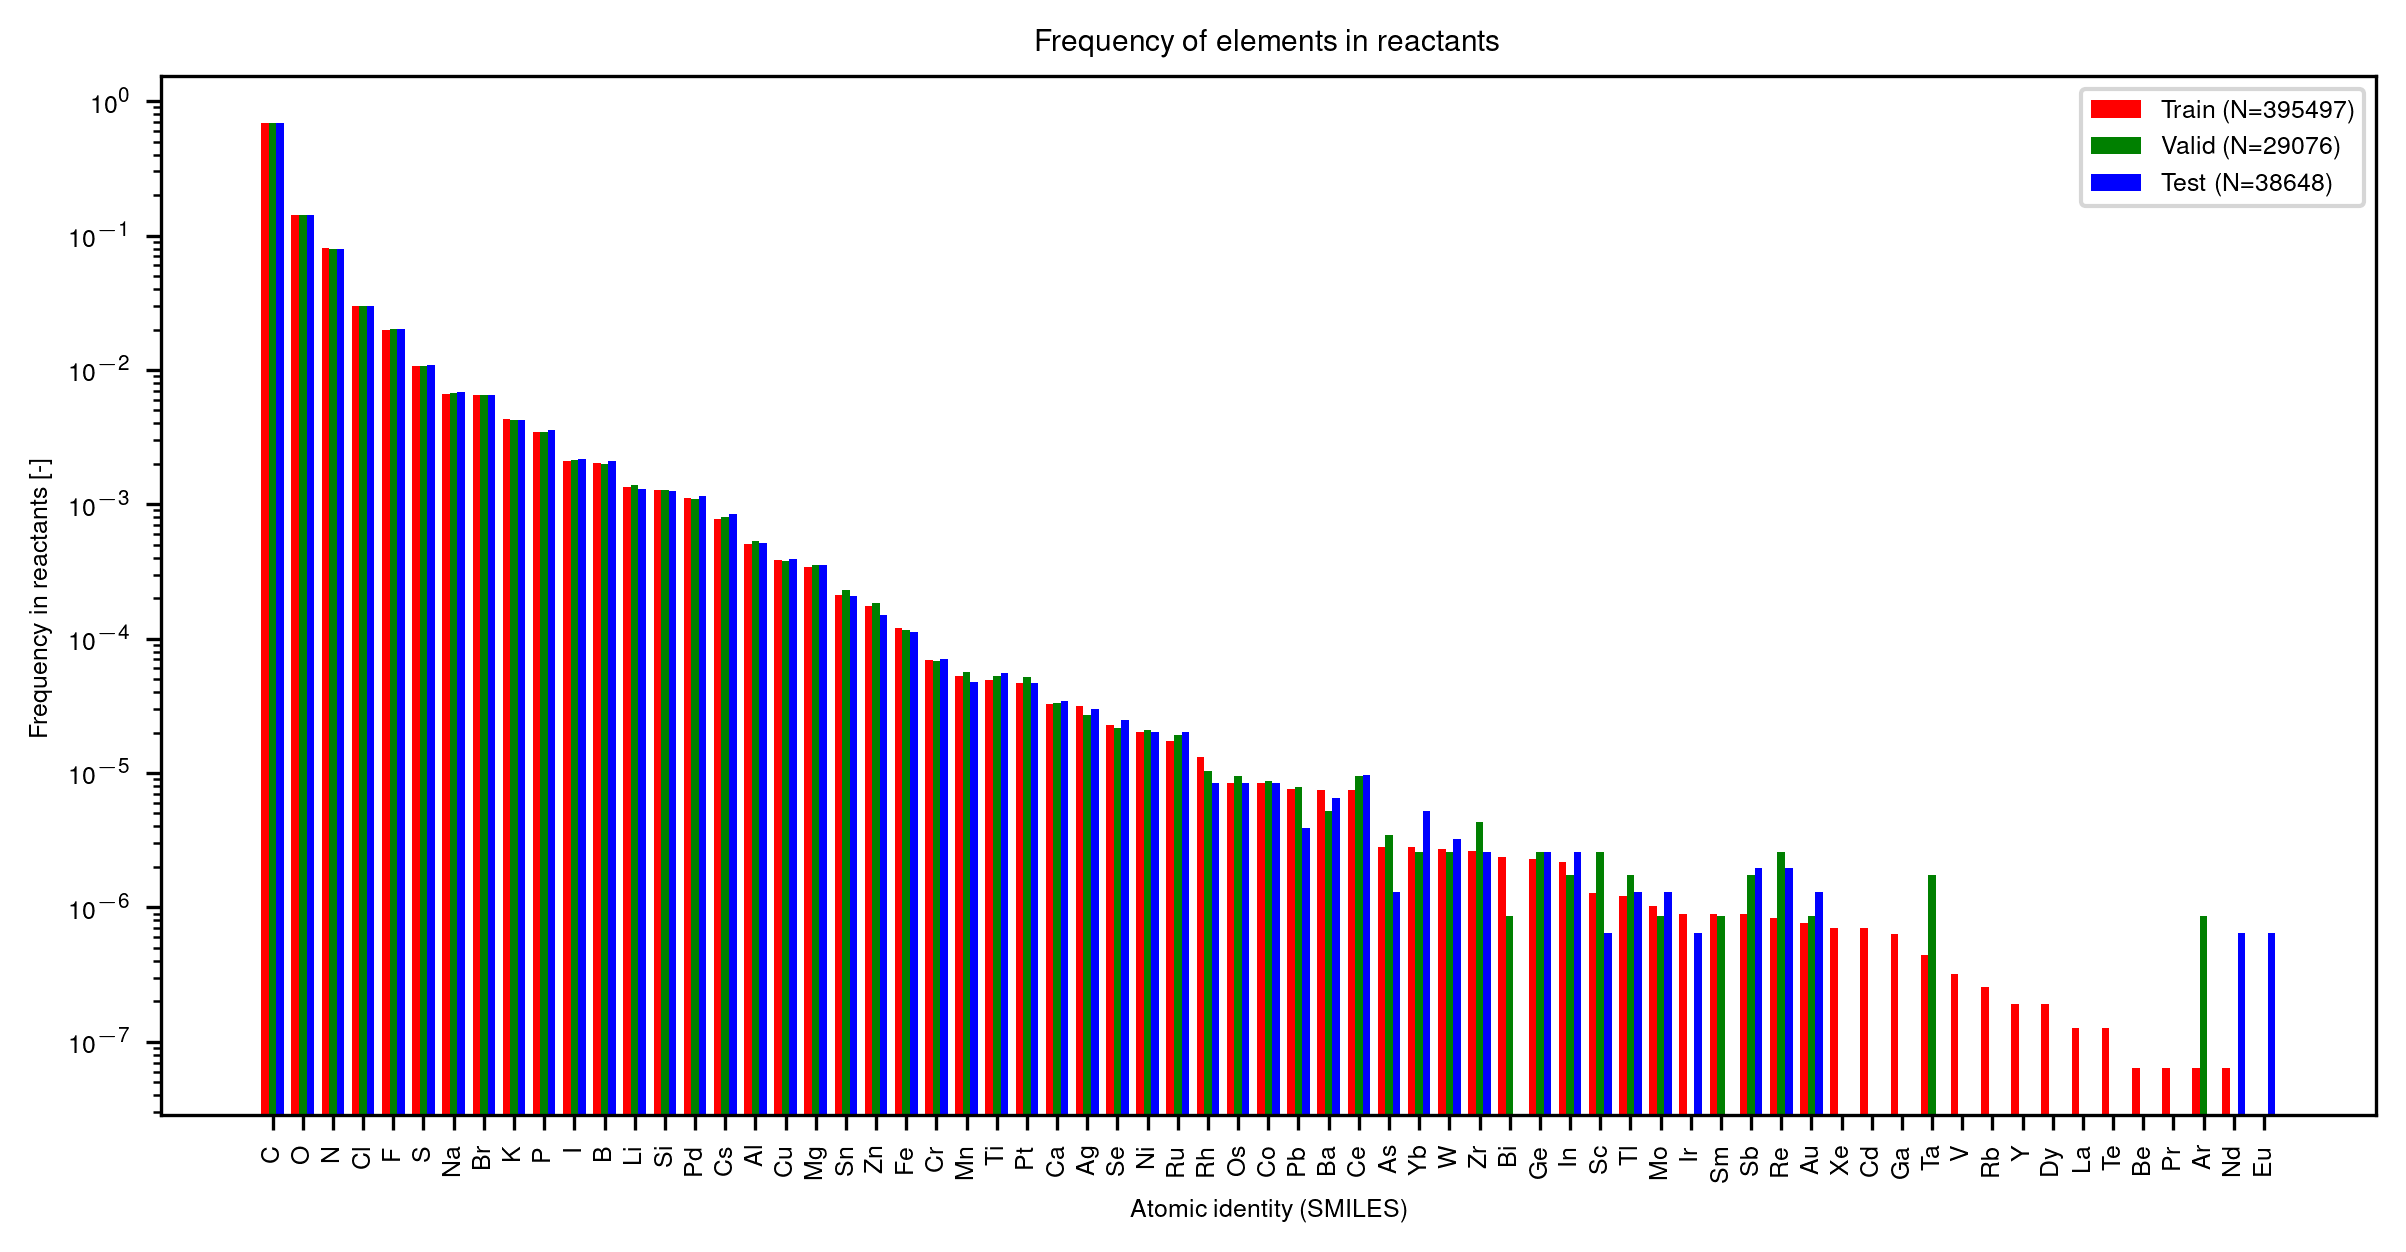

In [133]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['r', 'g', 'b']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_rcts[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    print('Freq Carbon in {}: {:.2f}%'.format(key, 100*vals[0]/np.sum(vals)))
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in reactants [-]')
# plt.grid(True)
plt.legend(['Train (N={})'.format(len(USPTO50['train'])), 
            'Valid (N={})'.format(len(USPTO50['valid'])), 
            'Test (N={})'.format(len(USPTO50['test']))])
plt.yscale('log')
plt.tight_layout()
plt.title('Frequency of elements in reactants')
plt.savefig(os.getcwd()+'/analysis/atom_type_freqs.png', bbox_inches = 'tight')
plt.show()

## Observations: 
- $C$ obviously most abundant, ~68.6% of all reactants across train/val/test
- $Na$, $K$, $Li$ relatively high frequency --> bases? $NaOH$, $K_{2}CO_{3}$ etc.? 
- Could be reagents too, like $LiAlH_{4}$, or counter-ions like $CH_{3}COO^{-}Na^{+}$ or salts like $LiClO_{4}$
- $Pd$ quite abundant, the most frequent transition metal element (1 in ~1000)
- $B$ too (Boronic Acids --> Suzuki Coupling?) or could be some borylation reactions (usu catalysed by $Ir$, $Pd$, $Ni$)
- Lanthanides $Nd$ (~10x), $Eu$ (non-existent in train?) much more abundant in test set vs train/valid (least frequent in train) --> Lanthanides worth looking into
- Noble elements $Xe$, $Ar$ rare but $Ar$ seems ~10x more frequent in val than train --> explore Noble gases 

- Check for things like Rhodium catalysed rxn + Ar

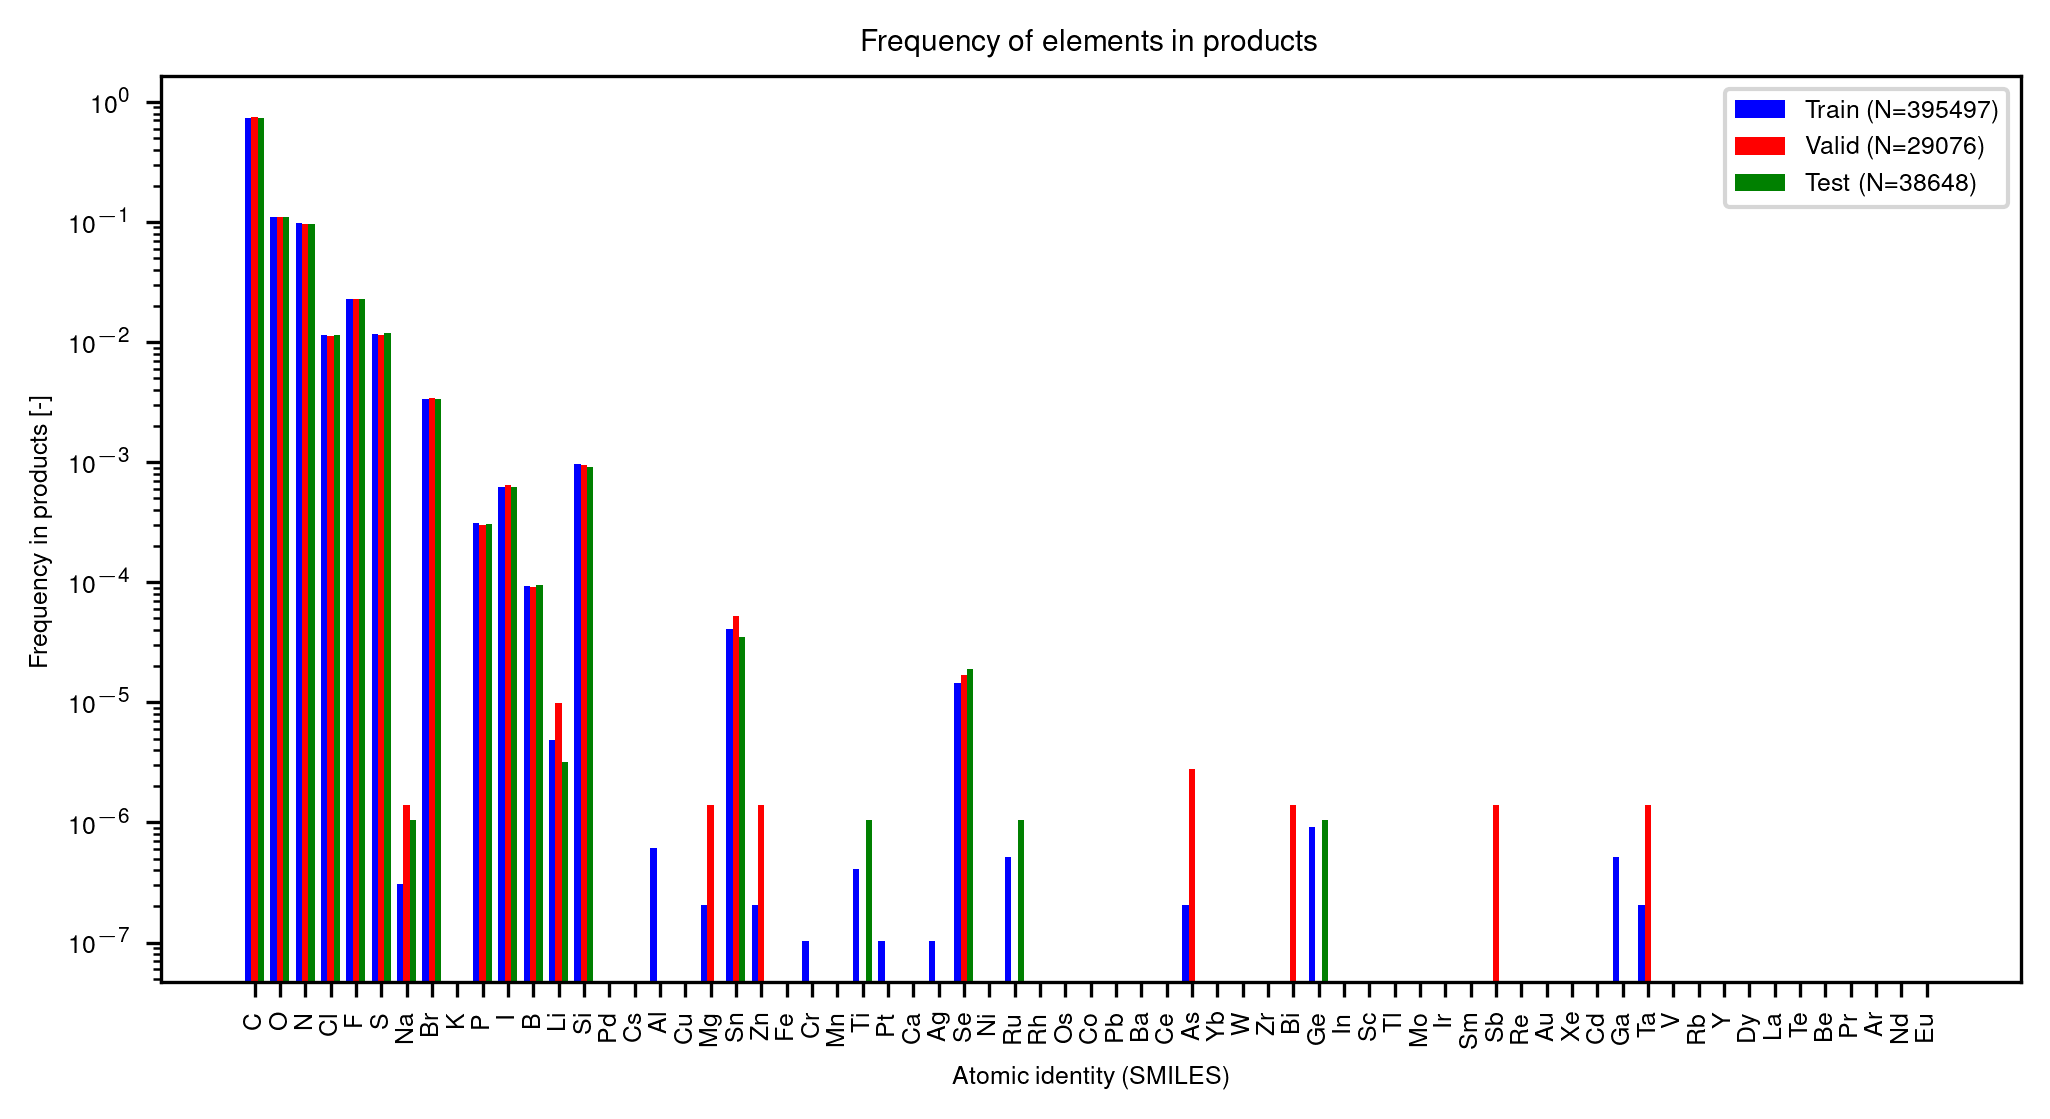

In [76]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_prods[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in products [-]')
# plt.grid(True)
plt.legend(['Train (N={})'.format(len(USPTO50['train'])), 
            'Valid (N={})'.format(len(USPTO50['valid'])), 
            'Test (N={})'.format(len(USPTO50['test']))])
plt.yscale('log')
plt.title('Frequency of elements in products')
plt.savefig(os.getcwd()+'/analysis/atom_type_freqs_prods.png', bbox_inches = 'tight')
plt.show()

### To make:
- Compare freq of diff 'grps' e.g. halogens, transition metals, lanthanides, noble gases
- Maybe a bar chart
- Do I need to manually construct the list of element abbrev or is there a neat RDKit class/object for it??

### Calculate unique # products, unique # reactants & reagents

In [77]:
products = {}
for key in USPTO50.keys():
    products[key] = [smarts.split('>')[-1] for smarts in USPTO50[key]]

unique_products = {}
for key in USPTO50.keys():
    unique_products[key] = set(products[key])
    print('# reactions in {}: {}'.format(key, len(products[key])))
    print('# unique pdts in {}: {} \n'.format(key, len(unique_products[key])))

# reactions in train: 395497
# unique pdts in train: 385427 

# reactions in valid: 29076
# unique pdts in valid: 29004 

# reactions in test: 38648
# unique pdts in test: 38509 



In [78]:
reactants = {}
for key in USPTO50.keys():
    reactants[key] = [smarts.split('>')[0].split('.') for smarts in USPTO50[key]]
    
unique_reactants = {}
for key in USPTO50.keys():
    unique_reactants[key] = set(chain.from_iterable(reactants[key]))
    print('# reactions in {}: {}'.format(key, len(reactants[key])))
    print('# total reactants + reagents in {}: {}'.format(key, len(list(chain.from_iterable(reactants[key])))))
    print('# unique reactants + reagents in {}: {} \n'.format(key, len(unique_reactants[key])))

# reactions in train: 395497
# total reactants + reagents in train: 1896045
# unique reactants + reagents in train: 460907 

# reactions in valid: 29076
# total reactants + reagents in valid: 139876
# unique reactants + reagents in valid: 55875 

# reactions in test: 38648
# total reactants + reagents in test: 186317
# unique reactants + reagents in test: 70536 



### Build dataframes to keep track of which reactants, reagents & product belonged to the same reaction
https://github.com/tentrillion/rdkit-tutorials/blob/master/notebooks/004_RDKit_pandas_support.ipynb

### dataframe where each row contains: 1 full rxn in SMILES, each reactant in 1 col each, product in 1 col

In [89]:
full_df = {'train': None, 'valid': None, 'test': None}
for key in full_df.keys():
    full_df[key] = pd.DataFrame(data=reactants[key])
    full_df[key].columns = ['reactant_{}'.format(n+1) for n in full_df[key].columns]
    full_df[key]['product'] = products[key]
    full_df[key]['reaction'] = USPTO50[key]

full_df['train'].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction
0,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19],[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1,[Cl-:14],[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19].[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1.[Cl-:14].[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1>>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1
1,[CH3:14][NH2:15],[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13],[OH2:16],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],[CH3:14][NH2:15].[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13].[OH2:16]>>[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14]
2,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12,[CH:25](=[O:26])[OH:27],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12.[CH:25](=[O:26])[OH:27]>>[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12
3,[Cl:1][C:2]([N:3]([CH3:4])[CH3:5])=[C:6]([CH3:7])[CH3:8],[Cl:51][CH2:52][Cl:53],[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:26])[OH:27])[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1,[NH2:37][c:38]1[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]1,[cH:45]1[cH:46][cH:47][n:48][cH:49][cH:50]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:27])[NH:37][c:38]4[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]4)[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1,[Cl:1][C:2]([N:3]([CH3:4])[CH3:5])=[C:6]([CH3:7])[CH3:8].[Cl:51][CH2:52][Cl:53].[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:26])[OH:27])[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1.[NH2:37][c:38]1[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]1.[cH:45]1[cH:46][cH:47][n:48][cH:49][cH:50]1>>[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:27])[NH:37][c:38...
4,[Cl:11][c:12]1[c:13]2[c:14]([n:15][c:16](-[c:18]3[cH:19][cH:20][n:21][cH:22][cH:23]3)[n:17]1)[s:24][c:25]([Cl:27])[cH:26]2,[Cl:1][c:2]1[cH:3][c:4]([CH2:5][NH2:6])[cH:7][cH:8][c:9]1[Cl:10],None,None,None,None,None,None,None,None,None,

### dataframe containing all reactants w/ duplicates 
- useful for counting occurence of certain reactants/reagents

In [80]:
allrcts_df = {'train': None, 'valid': None, 'test': None}
for key in allrcts_df.keys():
    allrcts_df[key] = pd.DataFrame(data=chain(*reactants[key]), columns=['reactant'])

allrcts_df['train'].head()

,reactant
0,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19]
1,[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1
2,[Cl-:14]
3,[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1
4,[CH3:14][NH2:15]


### Explore reactions w/ 29 reactants (train) 
- anomaly/human error or just a weird reaction?

[Br-:25].[C:44]([O-:45])(=[O:46])[CH3:47].[C:49]([O-:50])(=[O:51])[CH3:52].[C:57]([O-:58])(=[O:59])[CH3:60].[C:62]([O-:63])(=[O:64])[CH3:65].[C:66]([O-:67])(=[O:68])[CH3:69].[C:71]([O-:72])(=[O:73])[CH3:74].[C:75]([O-:76])(=[O:77])[CH3:78].[C:79]([O-:80])(=[O:81])[CH3:82].[CH3:20][C:21](=[O:22])[O-:23].[CH3:84][C:85](=[O:86])[OH:87].[Cl:10][c:11]1[cH:12][c:13]([CH3:14])[c:15]([CH3:16])[cH:17][cH:18]1.[Cl:1][c:2]1[cH:3][cH:4][cH:5][c:6]([CH3:7])[c:8]1[CH3:9].[Cl:27][c:28]1[c:29]([C:37](=[O:38])[OH:39])[c:30]([C:31](=[O:32])[OH:33])[cH:34][cH:35][cH:36]1.[Co+2:48].[Mn+2:61].[Na+:19].[Na+:24].[O:26].[OH2:40].[OH2:41].[OH2:42].[OH2:43].[OH2:53].[OH2:54].[OH2:55].[OH2:56].[OH2:83].[Zr+4:70]>>[Cl:27][c:28]1[c:29]2[c:30]([cH:34][cH:35][cH:36]1)[C:31](=[O:33])[O:39][C:37]2=[O:38]


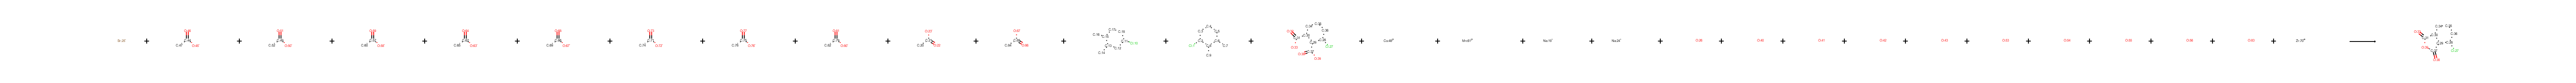

In [61]:
rct29_idx = full_df['train'].dropna().index.values.tolist() # rxn(s) with 29 reactants
rct29_rxn1 = USPTO50['train'][rct29_idx[0]]

print(rct29_rxn1)
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(rct29_rxn1), (200, 200))

### That's a lot of water molecules!
- is there a prettier way of printing reactions out? and how to show implicit hydrogens
- ReactionFromSmarts() seems to treat rxn as templates

### Add molecule column to dataframes for querying
- very slow! may be better to just use substring query using df.apply()

In [83]:
# import time
# start = time.process_time()

# for key in allrcts_df.keys():
#     PandasTools.AddMoleculeColumnToFrame(allrcts_df[key], smilesCol='reactant')
    
# print(time.process_time()-start)

269.53125


denominator shouldn't be allrcts_df['train'].shape[0], but rather total # of reactions in training set 

In [65]:
# %%time 

# halo_query =  Chem.MolFromSmarts('[F,Cl,Br,I]')
# allrcts_train_halo = allrcts_df['train'][allrcts_df['train']['ROMol'] >= halo_query] 

# print('% of reactants/reagents in {} w/ >= 1 halogen: {:.2f}'.format('train', 
#                                                                      100 * allrcts_train_halo.shape[0] / allrcts_df['train'].shape[0]))
# print('# of reactants/reagents in {} w/ >= 1 halogen: {}'.format('train', 
#                                                                  allrcts_train_halo.shape[0]))

% of reactants/reagents in train w/ >= 1 halogen: 27.98
# of reactants/reagents in train w/ >= 1 halogen: 530468
Wall time: 47.1 s


### use df.apply(check_substring) to query --> faster

In [100]:
def check_substring(row, substring_list, out=1):
    for substring in substring_list:
        if substring in row:
            return out
    return 1-out

### possible Suzuki couplings (to do: find better way of finding specific rxn: prolly by using SMARTS tokens or using the bond edits data)

In [108]:
for key in full_df.keys():
    full_df[key]['Pd'] = full_df[key].reaction.apply(check_substring, substring_list=['Pd'])
    full_df[key]['B'] = full_df[key].reaction.apply(check_substring, substring_list=['B:'])
    # have to put 'B:', otherwise 'Br' is wrongly included. Thankfully, B doesn't have charges

key = 'train'
suzuki = (full_df[key].B == 1) & (full_df[key].Pd == 1)
full_df[key][suzuki].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B
51,[C:16]([CH3:17])([CH3:18])([CH3:19])[O:20][C:21](=[O:22])[n:23]1[c:24]([B:33]2[O:34][C:35]([CH3:36])([CH3:37])[C:38]([CH3:39])([CH3:40])[O:41]2)[c:25]([CH3:32])[c:26]2[cH:27][cH:28][cH:29][cH:30][c:31]12,[C:42](=[O:43])([O-:44])[O-:45],[CH3:67][O:68][CH2:69][CH2:70][O:71][CH3:72],[CH3:83][CH2:84][O:85][C:86](=[O:87])[CH3:88],[I:1][c:2]1[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1,[K+:46],[K+:47],[O-:75][C:76]([CH3:77])=[O:78],[O-:79][C:80]([CH3:81])=[O:82],[OH2:73],[Pd+2:74],[c:48]1([P:49]([c:50]2[cH:51][cH:52][cH:53][cH:54][cH:55]2)[c:56]2[cH:57][cH:58][cH:59][cH:60][cH:61]2)[cH:62][cH:63][cH:64][cH:65][cH:66]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[c:2]1(-[c:24]2[n:23]([C:21]([O:20][C:16]([CH3:17])([CH3:18])[CH3:19])=[O:22])[c:31]3[c:26]([c:25]2[CH3:32])[cH:27][cH:28][cH:29][cH:30]3)[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1,[C:16]([CH3:17])([CH3:18])([CH3:19])[O:20][C:21](=[O:22])[n:23]1[c:24]([B:33]2[O:34][C:35]([CH3:36])([CH3:37])[C:38]([CH3:39])([CH3:40])[O:41]2)[c:25]([CH3:32])[c:26]2[cH:27][cH:28][cH:29][cH:30][c:31]12.[C:42](=[O:43])([O-:44])[O-:45].[CH3:67][O:68][CH2:69][CH2:70][O:71][CH3:72].[CH3:83][CH2:84][O:85][C:86](=[O:87])[CH3:88].[I:1][c:2]1[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1.[K+:46].[K+:47].[O-:75][C:76]([CH3:77])=[O:78].[O-:79][C:80]([CH3:81])=...,1,1
115,[Br:1][c:2]1[cH:3][cH:4][c:5]([O:8][CH2:9][C:10]([CH3:11])([OH:12])[CH3:13])[n:6][cH:7]1,[CH3:54][O:55][CH2:56][CH2:57][O:58][CH3:59],[CH3:60][CH2:61][OH:62],[Na+:53],[O-:49][C:50]([OH:51])=[O:52],[OH:14][C:15]([CH2:16][C:17]1([c:41]2[cH:42][cH:43][cH:44][cH:45][cH:46]2)[CH2:18][CH2:19][N:20]([CH:24]([CH3:25])[c:26]2[cH:27][cH:28][c:29]([B:32]3[O:33][C:34]([CH3:35])([CH3:36])[C:37]([CH3:38])([CH3:39])[O:40]3)[cH:30][cH:31]2)[C:21](=[O:23])[O:22]1)([CH3:47])[CH3:48],[cH:63]1[cH:64][cH:65][c:66]([P:67]([Pd:68]([P:69]([c:70]2[cH:71][cH:72][cH:73][cH:74][cH:75]2)([c:76]2[cH:77][cH:78][cH:79][cH:80][cH:81]2)[c:82]2[cH:83][cH:84][cH:85][cH:86][cH:87]2)([P:88]([c:89]2[cH:90][cH:91][cH:92][cH:93][cH:94]2)([c:95]2[cH:96][cH:97][cH:98][cH:99][cH:100]2)[c:101]2[cH:102][cH:103][cH:104][cH:105][cH:106]2)[P:107]([c:108]2[cH:109][cH:110][cH:111][cH:112][cH:113]2)([c:114]2[cH:115][cH:116][cH:117][cH:118][cH:119]2)[c:120]2[cH:121][cH:122][cH:123][cH:124][cH:125]2)([c:1...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[c:2]1(-[c:29]2[cH:28][cH:27][c:26]([CH:24]([N:20]3[CH2:19][CH2:18][C:17]([CH2:16][C:15]([OH:14])([CH3:47])[CH3:48])([c:41]4[cH:42][cH:43][cH:44][cH:45][cH:46]4)[O:22][C:21]3=[O:23])[CH3:25])[cH:31][cH:30]2)[cH:3][cH:4][c:5]([O:8][CH2:9][C:10]([CH3:11])([OH:12])[CH3:13])[n:6][cH:7]1,[Br:1][c:2]1[cH:3][cH:4][c:5]([O:8][CH2:9][C:10]([CH3:11])([OH:12])[CH3:13])[n:6][cH:7]1.[CH3:54][O:55][CH2:56][CH2:57][O:58][CH3:59].[CH3:60][CH2:61][OH:62].[Na+:53].[O-:49][C:50]([OH:51])=[O:52].[OH:14][C:15]([CH2:16][C:17]1([c:41]2[cH:42][cH:43][cH:44][cH:45][cH:46]2)[CH2:18][CH2:19][N:20]([CH:24]([CH3:25])[c:26]2[cH:27][cH:28][c:29]([B:32]3[O:33][C:34]([CH3:35])([CH3:36])[C:37]([CH3:38])([CH3:39])[O:40]3)[cH:30][cH:31]2)[C:21](=[O:23])[O:22]1)([CH3:47])[CH3:48].[cH:63]1[cH:64][cH:65][c:6...,1,1
120,[Br:1][c:2]1[c:3]([CH3:9])[cH:4][cH:5][c:6]([CH3:8])[cH:7]1,[CH2:23]([CH2:24][CH2:25][CH2:26][CH2:27][CH3:28])[O:29][c:30]1[cH:31][cH:32][c:33]([B:36]([OH:37])[OH:38])[cH:34][cH:35]1,[CH3:16][c:17]1[cH:18][cH:19][cH:20][cH:21][cH:22]1,[K+:10],[K+:11],[O-:12][C:13]([O-:14])=[O:15],[O

In [119]:
for key in full_df.keys():
    suzuki = (full_df[key].B == 1) & (full_df[key].Pd == 1)
    print('likely Suzuki coupling in {}: {:.3f}%'.format(key, 
                                                         100 * full_df[key][suzuki].shape[0] / full_df[key].shape[0]))
    print('# in {}: {}'.format(key, full_df[key][suzuki].shape[0]))

likely Suzuki coupling in train: 1.297%
# in train: 5129
likely Suzuki coupling in valid: 1.204%
# in valid: 350
likely Suzuki coupling in test: 1.400%
# in test: 541


### Randomly selects a rxn fitting specified criteria

idx chosen: 270585


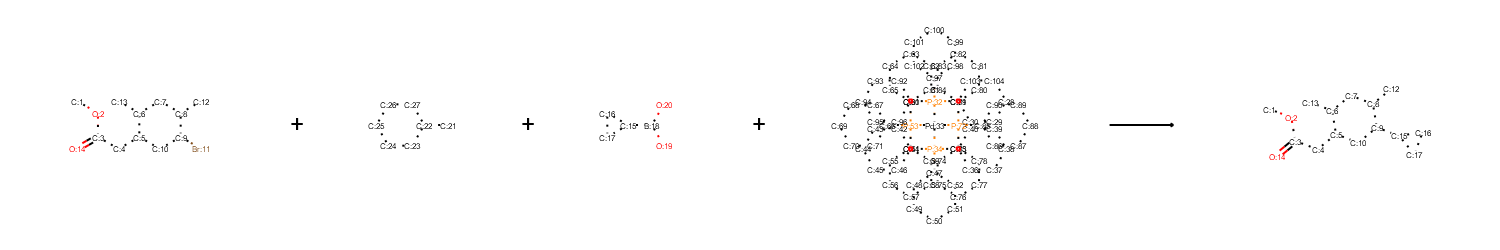

In [160]:
key = 'train'
suzuki = (full_df[key].B == 1) & (full_df[key].Pd == 1)
suzuki_idx = random.choice(full_df[key][suzuki].index.values.tolist())
current_rxn = rdChemReactions.ReactionFromSmarts(full_df[key].iloc[suzuki_idx].reaction)

print('idx chosen:', suzuki_idx)
Draw.ReactionToImage(current_rxn, (250, 250))

### Transition metals

In [129]:
TM_list = ['Pd', 'Cu', 'Fe', 'Cr', 'Mn', 'Ti', 'Pt', 'Ni', 'Ru', 'Rh', 'Os', 'Co', 'W', 'Zr', 'Mo', 'Ir',
          'Sc', 'Re', 'Au', 'Ta', 'V', 'Y', 'La']

for key in full_df.keys():
    full_df[key]['TM'] = full_df[key].reaction.apply(check_substring, substring_list=TM_list)

key = 'train'
TM = (full_df[key].TM == 1)  
full_df[key][TM].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B,TM
51,[C:16]([CH3:17])([CH3:18])([CH3:19])[O:20][C:21](=[O:22])[n:23]1[c:24]([B:33]2[O:34][C:35]([CH3:36])([CH3:37])[C:38]([CH3:39])([CH3:40])[O:41]2)[c:25]([CH3:32])[c:26]2[cH:27][cH:28][cH:29][cH:30][c:31]12,[C:42](=[O:43])([O-:44])[O-:45],[CH3:67][O:68][CH2:69][CH2:70][O:71][CH3:72],[CH3:83][CH2:84][O:85][C:86](=[O:87])[CH3:88],[I:1][c:2]1[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1,[K+:46],[K+:47],[O-:75][C:76]([CH3:77])=[O:78],[O-:79][C:80]([CH3:81])=[O:82],[OH2:73],[Pd+2:74],[c:48]1([P:49]([c:50]2[cH:51][cH:52][cH:53][cH:54][cH:55]2)[c:56]2[cH:57][cH:58][cH:59][cH:60][cH:61]2)[cH:62][cH:63][cH:64][cH:65][cH:66]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[c:2]1(-[c:24]2[n:23]([C:21]([O:20][C:16]([CH3:17])([CH3:18])[CH3:19])=[O:22])[c:31]3[c:26]([c:25]2[CH3:32])[cH:27][cH:28][cH:29][cH:30]3)[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1,[C:16]([CH3:17])([CH3:18])([CH3:19])[O:20][C:21](=[O:22])[n:23]1[c:24]([B:33]2[O:34][C:35]([CH3:36])([CH3:37])[C:38]([CH3:39])([CH3:40])[O:41]2)[c:25]([CH3:32])[c:26]2[cH:27][cH:28][cH:29][cH:30][c:31]12.[C:42](=[O:43])([O-:44])[O-:45].[CH3:67][O:68][CH2:69][CH2:70][O:71][CH3:72].[CH3:83][CH2:84][O:85][C:86](=[O:87])[CH3:88].[I:1][c:2]1[c:3]([O:14][CH3:15])[n:4][n:5][c:6](-[c:8]2[cH:9][cH:10][n:11][cH:12][cH:13]2)[cH:7]1.[K+:46].[K+:47].[O-:75][C:76]([CH3:77])=[O:78].[O-:79][C:80]([CH3:81])=...,1,1,1
79,[CH3:38][CH2:39][OH:40],[CH:1]([CH3:2])([CH3:3])[O:4][c:5]1[c:6]2[c:11]([cH:12][cH:13][n:14]1)[NH:10][C:9]([CH3:15])=[C:8]([C:16](=[O:17])[O:18][CH2:19][c:20]1[cH:21][cH:22][cH:23][cH:24][cH:25]1)[CH:7]2[c:26]1[c:27]([C:32]([F:33])([F:34])[F:35])[cH:28][cH:29][cH:30][cH:31]1,[H:36][H:37],[Pd:41],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH:1]([CH3:2])([CH3:3])[O:4][c:5]1[c:6]2[c:11]([cH:12][cH:13][n:14]1)[NH:10][C:9]([CH3:15])=[C:8]([C:16](=[O:17])[OH:18])[CH:7]2[c:26]1[c:27]([C:32]([F:33])([F:34])[F:35])[cH:28][cH:29][cH:30][cH:31]1,[CH3:38][CH2:39][OH:40].[CH:1]([CH3:2])([CH3:3])[O:4][c:5]1[c:6]2[c:11]([cH:12][cH:13][n:14]1)[NH:10][C:9]([CH3:15])=[C:8]([C:16](=[O:17])[O:18][CH2:19][c:20]1[cH:21][cH:22][cH:23][cH:24][cH:25]1)[CH:7]2[c:26]1[c:27]([C:32]([F:33])([F:34])[F:35])[cH:28][cH:29][cH:30][cH:31]1.[H:36][H:37].[Pd:41]>>[CH:1]([CH3:2])([CH3:3])[O:4][c:5]1[c:6]2[c:11]([cH:12][cH:13][n:14]1)[NH:10][C:9]([CH3:15])=[C:8]([C:16](=[O:17])[OH:18])[CH:7]2[c:26]1[c:27]([C:32]([F:33])([F:34])[F:35])[cH:28][cH:29][cH:30][cH:31]1,1,0,1
86,[C:29]([O-:30])(=[O:31])[CH3:32],[C:34]([O-:35])(=[O:36])[CH3:37],[CH3:14][c:15]1[n:16][nH:17][cH:18][cH:19]1,[Cl:26][CH2:27][Cl:28],[Cu+2:33],[F:1][C:2]([c:3]1[cH:4][cH:5][c:6]([B:9]([OH:10])[OH:11])[cH:7][cH:8]1)([F:12])[F:13],[cH:20]1[cH:21][cH:22][n:23][cH:24][cH:25]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[F:1][C:2]([c:3]1[cH:4][cH:5][c:6](-[n:17]2[n:16][c:15]([CH3:14])[cH:19][cH:18]2)[cH:7][cH:8]1)([F:12])[F:13],[C:29]([O-:30])(=[O:31])[CH3:32].[C:34]([O-:35])(=[O:36])[CH3:37].[CH3:14][c:15]1[n:16][nH:17][cH:18][cH:19]1.[Cl:26][CH2:27][Cl:28].[Cu+2:33].[F:1][C:2]([c:3]1[cH:4][cH:5][c:6]([B:9]([OH:10])[OH:11])[cH:7][cH:8]1)([F:12])[F:13].[cH:20]1[cH:21][cH:22][n:23][cH:24][cH:25]1>>[F:1][C:2]([c:3]1[cH:4][cH:5][c:6](-[n:17]2[n:16][c:15]([CH3:14])[cH:19][cH:18]2)[cH:7][cH:8]1)([F:12])[F:13],0,1,1
104,[C:1]([CH3:2])(=[O:3])[O:4][CH:5]1[CH:6]([c:24]2[cH:25][c:26]([CH2:31][c:32]3[s:33][c:34]([Br:37])[cH:35][cH:36]3)[c:27]([CH3:30])[

In [136]:
for key in full_df.keys():
    TM = (full_df[key].TM == 1)
    print('Rxn w/ Transition Metal(s) in {}: {:.3f}%'.format(key, 
                                                         100 * full_df[key][TM].shape[0] / full_df[key].shape[0]))
    print('# in {}: {}'.format(key, full_df[key][TM].shape[0]))

Rxn w/ Transition Metal(s) in train: 6.594%
# in train: 26079
Rxn w/ Transition Metal(s) in valid: 6.486%
# in valid: 1886
Rxn w/ Transition Metal(s) in test: 6.738%
# in test: 2604


### Halogens

In [134]:
halo_list = ['F', 'Cl', 'Br', 'I']

for key in full_df.keys():
    full_df[key]['Halo'] = full_df[key].reaction.apply(check_substring, substring_list=halo_list)

key = 'train'
halo = (full_df[key].Halo == 1)  
full_df[key][halo].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B,TM,Halo
0,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19],[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1,[Cl-:14],[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19].[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1.[Cl-:14].[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1>>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,0,0,0,1
1,[CH3:14][NH2:15],[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13],[OH2:16],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],[CH3:14][NH2:15].[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13].[OH2:16]>>[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],0,0,0,1
2,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12,[CH:25](=[O:26])[OH:27],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12.[CH:25](=[O:26])[OH:27]>>[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,0,0,0,1
3,[Cl:1][C:2]([N:3]([CH3:4])[CH3:5])=[C:6]([CH3:7])[CH3:8],[Cl:51][CH2:52][Cl:53],[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:26])[OH:27])[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1,[NH2:37][c:38]1[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]1,[cH:45]1[cH:46][cH:47][n:48][cH:49][cH:50]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:27])[NH:37][c:38]4[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]4)[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1,[Cl:1][C:2]([N:3]([CH3:4])[CH3:5])=[C:6]([CH3:7])[CH3:8].[Cl:51][CH2:52][Cl:53].[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:26])[OH:27])[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1.[NH2:37][c:38]1[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]1.[cH:45]1[cH:46][cH:47][n:48][cH:49][cH:50]1>>[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:27])[NH:37][c:38...,0,0,0,1
4,[Cl:11][c:12]1[c:13]2[c:14]([n:15][c:16](-[c:18]3[cH:19][cH:20][n:21][cH:22][cH:23]3)[n:17]1)[s:24][c:25]([Cl:27])[cH:26]2,[Cl:1][c:2]1[cH:3][c:4]([CH2:5][NH2:6])[cH:7][cH:8][c:9]1[Cl:10],

In [135]:
for key in full_df.keys():
    halo = (full_df[key].Halo == 1)
    print('Rxn w/ halogen(s) in {}: {:.3f}%'.format(key, 
                                                    100 * full_df[key][halo].shape[0] / full_df[key].shape[0]))
    print('# in {}: {}'.format(key, full_df[key][halo].shape[0]))

Rxn w/ halogen(s) in train: 80.934%
# in train: 320091
Rxn w/ halogen(s) in valid: 80.895%
# in valid: 23521
Rxn w/ halogen(s) in test: 81.088%
# in test: 31339


Check whether halogen appears in reactant 

### Noble elements

In [137]:
noble_list = ['He', 'Ar', 'Ne', 'Xe', 'Kr', 'Og', 'Rn']

for key in full_df.keys():
    full_df[key]['Noble'] = full_df[key].reaction.apply(check_substring, substring_list=noble_list)

key = 'train'
noble = (full_df[key].Noble == 1)  
full_df[key][noble].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B,TM,Halo,Noble
725,[C:35](=[O:36])([O-:37])[OH:38],[CH3:40][C:41]#[N:42],[CH:1]1([S:4](=[O:5])(=[O:6])[c:7]2[cH:8][cH:9][c:10]([CH:13]([CH2:14][CH:15]3[CH2:16][CH2:17][O:18][CH2:19][CH2:20]3)[c:21]3[nH:22][c:23](-[c:26]4[n:27][cH:28][cH:29][cH:30][cH:31]4)[cH:24][n:25]3)[cH:11][cH:12]2)[CH2:2][CH2:3]1,[Na+:39],[Xe:32]([F:33])[F:34],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH:1]1([S:4](=[O:5])(=[O:6])[c:7]2[cH:8][cH:9][c:10]([CH:13]([CH2:14][CH:15]3[CH2:16][CH2:17][O:18][CH2:19][CH2:20]3)[c:21]3[nH:22][c:23](-[c:26]4[n:27][cH:28][cH:29][cH:30][cH:31]4)[c:24]([F:33])[n:25]3)[cH:11][cH:12]2)[CH2:2][CH2:3]1,[C:35](=[O:36])([O-:37])[OH:38].[CH3:40][C:41]#[N:42].[CH:1]1([S:4](=[O:5])(=[O:6])[c:7]2[cH:8][cH:9][c:10]([CH:13]([CH2:14][CH:15]3[CH2:16][CH2:17][O:18][CH2:19][CH2:20]3)[c:21]3[nH:22][c:23](-[c:26]4[n:27][cH:28][cH:29][cH:30][cH:31]4)[cH:24][n:25]3)[cH:11][cH:12]2)[CH2:2][CH2:3]1.[Na+:39].[Xe:32]([F:33])[F:34]>>[CH:1]1([S:4](=[O:5])(=[O:6])[c:7]2[cH:8][cH:9][c:10]([CH:13]([CH2:14][CH:15]3[CH2:16][CH2:17][O:18][CH2:19][CH2:20]3)[c:21]3[nH:22][c:23](-[c:26]4[n:27][cH:28][cH:29][cH:30][cH:31...,0,0,0,1,1
20524,[CH3:1][C:2]([CH:3]([CH3:4])[CH3:5])([c:6]1[cH:7][cH:8][c:9](-[c:12]2[cH:13][n:14][cH:15][c:16]([O:18][CH2:19][S:20][CH3:21])[cH:17]2)[cH:10][cH:11]1)[c:22]1[cH:23][cH:24][c:25](-[c:28]2[n:29][n:30][c:31]([C:34]([F:35])([F:36])[F:37])[cH:32][cH:33]2)[cH:26][n:27]1,[Cl:41][CH2:42][CH2:43][Cl:44],[Xe:38]([F:39])[F:40],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH3:1][C:2]([CH:3]([CH3:4])[CH3:5])([c:6]1[cH:7][cH:8][c:9](-[c:12]2[cH:13][n:14][cH:15][c:16]([O:18][CH2:19][F:39])[cH:17]2)[cH:10][cH:11]1)[c:22]1[cH:23][cH:24][c:25](-[c:28]2[n:29][n:30][c:31]([C:34]([F:35])([F:36])[F:37])[cH:32][cH:33]2)[cH:26][n:27]1,[CH3:1][C:2]([CH:3]([CH3:4])[CH3:5])([c:6]1[cH:7][cH:8][c:9](-[c:12]2[cH:13][n:14][cH:15][c:16]([O:18][CH2:19][S:20][CH3:21])[cH:17]2)[cH:10][cH:11]1)[c:22]1[cH:23][cH:24][c:25](-[c:28]2[n:29][n:30][c:31]([C:34]([F:35])([F:36])[F:37])[cH:32][cH:33]2)[cH:26][n:27]1.[Cl:41][CH2:42][CH2:43][Cl:44].[Xe:38]([F:39])[F:40]>>[CH3:1][C:2]([CH:3]([CH3:4])[CH3:5])([c:6]1[cH:7][cH:8][c:9](-[c:12]2[cH:13][n:14][cH:15][c:16]([O:18][CH2:19][F:39])[cH:17]2)[cH:10][cH:11]1)[c:22]1[cH:23][cH:24][c:25](-[c:28]...,0,0,0,1,1
29941,[CH3:36][C:37]#[N:38],[CH:1]1([C:5](=[O:6])[c:7]2[cH:8][n:9][c:10]([CH:12]([CH2:13][CH:14]3[CH2:15][C:16](=[O:19])[CH2:17][CH2:18]3)[c:20]3[cH:21][cH:22][c:23]([S:26](=[O:27])(=[O:28])[CH:29]4[CH2:30][CH2:31]4)[cH:24][cH:25]3)[nH:11]2)[CH2:2][CH2:3][CH2:4]1,[OH2:35],[Xe:32]([F:33])[F:34],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH:1]1([C:5](=[O:6])[c:7]2[c:8]([F:33])[n:9][c:10]([CH:12]([CH2:13][CH:14]3[CH2:15][C:16](=[O:19])[CH2:17][CH2:18]3)[c:20]3[cH:21][cH:22][c:23]([S:26](=[O:27])(=[O:28])[CH:29]4[CH2:30][CH2:31]4)[cH:24][cH:25]3)[nH:11]2)[CH2:2][CH2:3][CH2:4]1,[CH3:36][C:37]#[N:38].[CH:1]1([C:5](=[O:6])[c:7]2[cH:8][n:9][c:10]([CH:12]([CH2:13][CH:14]3[CH2:15][C:16](=[O:19])[CH2:17][CH2:18]3)[c:20]3[cH:21][cH:22][c:23]([S:26](=[O:27])(=[O:28])[CH:29]4[CH2:30][CH2:31]4)[cH:24][cH:25]3)[nH:11]2)[CH2:2][CH2:3][CH2:4]1.[OH2:35].[Xe:32]([F:33])[F:34]>>[CH:1]1([C:5](=[O:6])[c:7]2[c:8]([F:33])[n:9][c:10]([CH:12]([CH2:13][CH:14]3[CH2:15][C:16](=[O:19])[CH2:17][CH2:18]3)[c:20]3[cH:21][cH:22][c:23]([S:26](=[O:27])(=[O:28])[CH:29]4[CH2:30][CH2:31]4)[cH:24][cH:...,0,0,0,1,1
31790,[Ar:15],[C:33](=[O:34])([O-:35])[O-:36

In [139]:
for key in full_df.keys():
    noble = (full_df[key].Noble == 1)
    print('Rxn w/ Noble element(s) in {}: {:.4f}%'.format(key, 
                                                    100 * full_df[key][noble].shape[0] / full_df[key].shape[0]))
    print('# in {}: {}'.format(key, full_df[key][noble].shape[0]))

Rxn w/ Noble element(s) in train: 0.0033%
# in train: 13
Rxn w/ Noble element(s) in valid: 0.0034%
# in valid: 1
Rxn w/ Noble element(s) in test: 0.0000%
# in test: 0


### Lanthanides

In [140]:
lanth_list = ['Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']

for key in full_df.keys():
    full_df[key]['Lanthanide'] = full_df[key].reaction.apply(check_substring, substring_list=lanth_list)

key = 'train'
lanth = (full_df[key].Lanthanide == 1)  
full_df[key][lanth].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B,TM,Halo,Noble,Lanthanide
1267,[CH3:20][c:21]1[cH:22][cH:23][c:24]([O:27][CH3:28])[cH:25][cH:26]1,[CH3:29][OH:30],[Ce+3:5],[Ce:19],[N+:10]([O-:11])([O-:12])=[O:13],[N+:1]([O-:2])([O-:3])=[O:4],[N+:6]([O-:7])([O-:8])=[O:9],[NH4+:14],[O-:15][N+:16](=[O:17])[O-:18],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[O:15]=[CH:20][c:21]1[cH:22][cH:23][c:24]([O:27][CH3:28])[cH:25][cH:26]1,[CH3:20][c:21]1[cH:22][cH:23][c:24]([O:27][CH3:28])[cH:25][cH:26]1.[CH3:29][OH:30].[Ce+3:5].[Ce:19].[N+:10]([O-:11])([O-:12])=[O:13].[N+:1]([O-:2])([O-:3])=[O:4].[N+:6]([O-:7])([O-:8])=[O:9].[NH4+:14].[O-:15][N+:16](=[O:17])[O-:18]>>[O:15]=[CH:20][c:21]1[cH:22][cH:23][c:24]([O:27][CH3:28])[cH:25][cH:26]1,0,0,0,0,0,1
2867,[CH3:31][C:32]#[N:33],[Ce:29],[N+:25](=[O:26])([O-:27])[O-:28],[NH4+:30],[c:1]1([S:7](=[O:8])(=[O:9])[CH2:10][CH2:11][n:12]2[c:13]3[cH:14][cH:15][cH:16][cH:17][c:18]3[c:19]3[cH:20][cH:21][cH:22][cH:23][c:24]23)[cH:2][cH:3][cH:4][cH:5][cH:6]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[c:1]1([S:7](=[O:8])(=[O:9])[CH2:10][CH2:11][n:12]2[c:13]3[cH:14][cH:15][cH:16][cH:17][c:18]3[c:19]3[cH:20][c:21]([N+:25](=[O:26])[O-:27])[cH:22][cH:23][c:24]23)[cH:2][cH:3][cH:4][cH:5][cH:6]1,[CH3:31][C:32]#[N:33].[Ce:29].[N+:25](=[O:26])([O-:27])[O-:28].[NH4+:30].[c:1]1([S:7](=[O:8])(=[O:9])[CH2:10][CH2:11][n:12]2[c:13]3[cH:14][cH:15][cH:16][cH:17][c:18]3[c:19]3[cH:20][cH:21][cH:22][cH:23][c:24]23)[cH:2][cH:3][cH:4][cH:5][cH:6]1>>[c:1]1([S:7](=[O:8])(=[O:9])[CH2:10][CH2:11][n:12]2[c:13]3[cH:14][cH:15][cH:16][cH:17][c:18]3[c:19]3[cH:20][c:21]([N+:25](=[O:26])[O-:27])[cH:22][cH:23][c:24]23)[cH:2][cH:3][cH:4][cH:5][cH:6]1,0,0,0,0,0,1
3458,[CH3:1][O:2][c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1,[F:17][C:18]([F:19])([F:20])[S:21]([O-:22])(=[O:23])=[O:24],[F:26][C:27]([F:28])([F:29])[S:30]([O-:31])(=[O:32])=[O:33],[F:34][C:35]([F:36])([F:37])[S:38]([O-:39])(=[O:40])=[O:41],[N+:42]([CH3:43])([O-:44])=[O:45],[Yb+3:25],[c:9]1([C:14](=[O:15])[Cl:16])[cH:10][cH:11][cH:12][s:13]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([C:14]([c:9]2[cH:10][cH:11][cH:12][s:13]2)=[O:15])[cH:7][cH:8]1,[CH3:1][O:2][c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1.[F:17][C:18]([F:19])([F:20])[S:21]([O-:22])(=[O:23])=[O:24].[F:26][C:27]([F:28])([F:29])[S:30]([O-:31])(=[O:32])=[O:33].[F:34][C:35]([F:36])([F:37])[S:38]([O-:39])(=[O:40])=[O:41].[N+:42]([CH3:43])([O-:44])=[O:45].[Yb+3:25].[c:9]1([C:14](=[O:15])[Cl:16])[cH:10][cH:11][cH:12][s:13]1>>[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([C:14]([c:9]2[cH:10][cH:11][cH:12][s:13]2)=[O:15])[cH:7][cH:8]1,0,0,1,1,0,1
3648,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([CH2:7][NH:8][CH2:9][c:10]2[c:11](-[c:21]3[c:22]([F:29])[cH:23][cH:24][cH:25][c:26]3[O:27][CH3:28])[n:12][c:13]3[c:14]([CH3:20])[cH:15][cH:16][cH:17][c:18]3[cH:19]2)[cH:30][cH:31]1,[Ce+4:36],[N+:32]([O-:33])([O-:34])=[O:35],[N+:38]([O-:39])([O-:40])=[O:41],[N+:42]([O-:43])([O-:44])=[O:45],[N+:46]([O-:47])([O-:48])=[O:49],[N+:50]([O-:51])([O-:52])=[O:53],[NH4+:37],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[NH2:8][CH2:9][c:10]1[c:11](-[c:21]2[c:22]([F:29])[cH:23][cH:24][cH:25][c:26]2[O:27][CH3:28])[n:12][c:13]2[c:14]([CH3:20])[cH:15][cH:16][cH:17][c:18]2[cH:19]1,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([CH2:7][NH:8][CH2:9][c:10]2[c:11](-[c:21]3[c:22]([F:29])[cH:23][cH:24][cH:25][c:26]3[O:27][CH3:28])[n:12][c:13]3[c:14]([CH3:20])[cH:15][cH:16][cH:17][c:18]3[cH:19]2)[cH:30][cH:

In [142]:
for key in full_df.keys():
    lanth = (full_df[key].Lanthanide == 1)
    print('Rxn w/ Lanthanide(s) in {}: {:.4f}%'.format(key, 
                                                    100 * full_df[key][lanth].shape[0] / full_df[key].shape[0]))
    print('# in {}: {}'.format(key, full_df[key][lanth].shape[0]))

Rxn w/ Lanthanide(s) in train: 0.0448%
# in train: 177
Rxn w/ Lanthanide(s) in valid: 0.0481%
# in valid: 14
Rxn w/ Lanthanide(s) in test: 0.0621%
# in test: 24


### filter reactants that do not contribute atoms to product --> possible solvents/catalysts etc.
https://github.com/Hanjun-Dai/GLN/blob/master/gln/data_process/clean_uspto.py

In [157]:
def get_rxn_smiles(prod_smi, reactants):
    '''
    Adapted func from Hanjun Dai's GLN to additionally keep track of reagents (reactants that don't appear in products)
    '''
    # Get rid of reactants when they don't contribute to this prod
    prod_maps = set(re.findall('\:([[0-9]+)\]', prod_smi))
    reactants_smi_list = []
    reagent_smi_list = []
    
    for mol in reactants:
        if mol is None:
            continue
            
        used = False
        for a in mol.GetAtoms():
            if a.HasProp('molAtomMapNumber'):
                if a.GetProp('molAtomMapNumber') in prod_maps:
                    used = True 
                    
                else:
                    a.ClearProp('molAtomMapNumber')
                    
        if used:
            reactants_smi_list.append(Chem.MolToSmiles(mol, True))
        else:
            reagent_smi_list.append(Chem.MolToSmiles(mol, True))
            
    reactants_smi = '.'.join(reactants_smi_list)
    
    if reagent_smi_list:
        reagents_smi = '.'.join(reagent_smi_list)
    else:
        reagents_smi = ''
        
    return '{}>{}>{}'.format(reactants_smi, reagents_smi, prod_smi)

### takes a while!! to do: any way to speed this up? 

In [158]:
def get_rxn_smiles_column(rxn_smiles):
    all_reactants, prod = rxn_smiles.split('>>')
    mol_reactants = [Chem.MolFromSmiles(smi) for smi in all_reactants.split('.')]
    
    return get_rxn_smiles(prod, mol_reactants)

full_df['train']['cleaned'] = full_df['train'].reaction.apply(get_rxn_smiles_column)

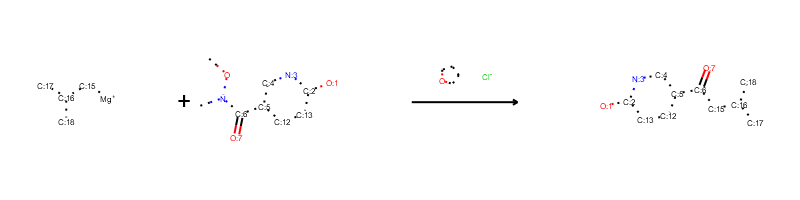

In [161]:
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(full_df['train'].cleaned.iloc[0]), (200, 200))

In [166]:
def get_reagents(cleaned_smiles):
    reagents = cleaned_smiles.split('>')[1]
    return reagents

full_df['train']['reagents'] = full_df['train'].cleaned.apply(get_reagents)

In [173]:
full_df['train'].head()

,reactant_1,reactant_2,reactant_3,reactant_4,reactant_5,reactant_6,reactant_7,reactant_8,reactant_9,reactant_10,reactant_11,reactant_12,reactant_13,reactant_14,reactant_15,reactant_16,reactant_17,reactant_18,reactant_19,reactant_20,reactant_21,reactant_22,reactant_23,reactant_24,reactant_25,reactant_26,reactant_27,reactant_28,reactant_29,product,reaction,Pd,B,TM,Halo,Noble,Lanthanide,cleaned,reagents
0,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19],[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1,[Cl-:14],[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19].[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1.[Cl-:14].[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1>>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,0,0,0,1,0,0,[Mg+][CH2:15][CH:16]([CH3:17])[CH3:18].CON(C)[C:6]([c:5]1[cH:4][n:3][c:2]([OH:1])[cH:13][cH:12]1)=[O:7]>C1CCOC1.[Cl-]>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1,C1CCOC1.[Cl-]
1,[CH3:14][NH2:15],[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13],[OH2:16],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],[CH3:14][NH2:15].[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[Cl:13].[OH2:16]>>[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],0,0,0,1,0,0,[CH3:14][NH2:15].Cl[c:12]1[c:4]([N+:1](=[O:2])[O-:3])[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11]1>O>[N+:1](=[O:2])([O-:3])[c:4]1[cH:5][c:6]([C:7](=[O:8])[OH:9])[cH:10][cH:11][c:12]1[NH:15][CH3:14],O
2,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12,[CH:25](=[O:26])[OH:27],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12.[CH:25](=[O:26])[OH:27]>>[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,0,0,0,1,0,0,[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH2:19])[cH:17][cH:18]3)[cH:11][c:12]12.O[CH:25]=[O:26]>>[CH2:1]([CH3:2])[n:3]1[cH:4][c:5]([C:22](=[O:23])[OH:24])[c:6](=[O:21])[c:7]2[cH:8][c:9]([F:20])[c:10](-[c:13]3[cH:14][cH:15][c:16]([NH:19][CH:25]=[O:26])[cH:17][cH:18]3)[cH:11][c:12]12,
3,[Cl:1][C:2]([N:3]([CH3:4])[CH3:5])=[C:6]([CH3:7])[CH3:8],[Cl:51][CH2:52][Cl:53],[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:26])[OH:27])[cH:28][c:29]([O:31][CH:32]([CH2:33][O:34][CH3:35])[CH3:36])[cH:30]3)[n:19][cH:20]2)[CH2:10][CH2:11][CH2:12]1,[NH2:37][c:38]1[n:39][cH:40][c:41]([CH3:44])[n:42][cH:43]1,[cH:45]1[cH:46][cH:47][n:48][cH:49][cH:50]1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[N:9]1([C:13](=[O:14])[c:15]2[n:16][cH:17][c:18]([O:21][c:22]3[cH:23][c:24]([C:25](=[O:27])[NH:37][c:38]4[n:

In [170]:
cleaned_smiles = {'train': None, 'valid': None, 'test': None}
cleaned_smiles['train'] = full_df['train'].cleaned.tolist()

reagents_list = [cleaned_smi.split('>')[1].split('.') for cleaned_smi in cleaned_smiles['train']]

In [172]:
reagents_df = {'train': None, 'valid': None, 'test': None}
reagents_df['train'] = pd.DataFrame(data=reagents_list)
reagents_df['train'].columns = ['reagent_{}'.format(n+1) for n in reagents_df['train'].columns]

reagents_df['train'].head()

,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,reagent_10,reagent_11,reagent_12,reagent_13,reagent_14,reagent_15,reagent_16,reagent_17,reagent_18,reagent_19,reagent_20,reagent_21,reagent_22,reagent_23,reagent_24,reagent_25,reagent_26,reagent_27,reagent_28
0,C1CCOC1,[Cl-],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,O,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,CC(C)=C(Cl)N(C)C,ClCCl,c1ccncc1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


### How to identify ligands? 
- NHC ligands, Phosphines (saw a bunch)
- ideas: substructure search for NHC
- for phosphine, search for P bonded to 3 other atoms? is that possible
- or search P + TM 

### How to identify solvents etc.
- substructure search for hardcoded list of solvents?
- or is there a more clever way of identifying solvents

### To do: PCA analysis

In [174]:

from rdkit import DataStructs
from rdkit.Chem import AllChem

class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circural (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn
    
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    
    if counts is True:
        info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures, bitInfo=info)
        DataStructs.ConvertToNumpyArray(fp, arr)
        arr = np.array([len(info[x]) if x in info else 0 for x in range(nBits)], dtype)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

In [175]:
PandasTools.AddMoleculeColumnToFrame(full_df['test'], smilesCol='product') 

In [177]:
full_df['test']['FP'] = full_df['test']['ROMol'].map(get_cfps)

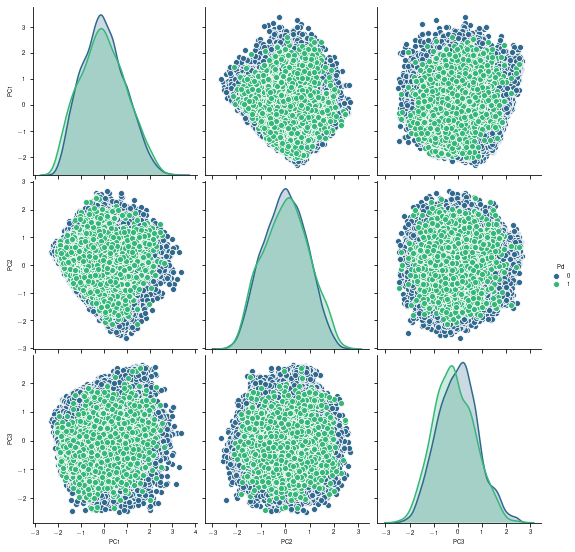

In [181]:
from sklearn.decomposition import PCA
X = np.array([x.fp for x in full_df['test']['FP']])
pca = PCA(n_components=3, random_state=0)
pca_products = pca.fit_transform(X)

full_df['test']['PC1'] = pca_products.T[0]
full_df['test']['PC2'] = pca_products.T[1]
full_df['test']['PC3'] = pca_products.T[2]

import seaborn as sns
sns.pairplot(full_df['test'], hue='Pd', vars=['PC1', 'PC2', 'PC3'], palette='viridis');

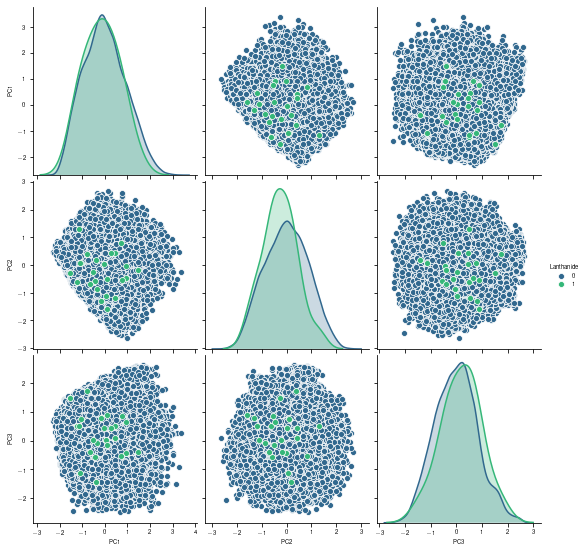

In [182]:
from sklearn.decomposition import PCA
X = np.array([x.fp for x in full_df['test']['FP']])
pca = PCA(n_components=3, random_state=0)
pca_products = pca.fit_transform(X)

full_df['test']['PC1'] = pca_products.T[0]
full_df['test']['PC2'] = pca_products.T[1]
full_df['test']['PC3'] = pca_products.T[2]

import seaborn as sns
sns.pairplot(full_df['test'], hue='Lanthanide', vars=['PC1', 'PC2', 'PC3'], palette='viridis');